In [118]:
import pandas as pd
import numpy as np
from keras.utils import np_utils
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import roc_auc_score,confusion_matrix, accuracy_score, make_scorer, f1_score,precision_score,recall_score, plot_confusion_matrix
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [119]:
def print_distribution(arr, print_nl=True):
    arr = np.unique(arr, return_counts=True)[1] / len(arr)
    for i in range(arr.shape[0]):
        print("Classe %d: %.2f%%" %(i, arr[i]*100))

    if print_nl:
        print("\n")

In [120]:
def taste(quality):
  if quality <= 5:
    return 0
  elif quality == 6:
    return 1
  else:
    return 2

In [121]:
data = pd.read_csv("wine_quality.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed.acidity         6497 non-null   float64
 1   volatile.acidity      6497 non-null   float64
 2   citric.acid           6497 non-null   float64
 3   residual.sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free.sulfur.dioxide   6497 non-null   float64
 6   total.sulfur.dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 609.2 KB


In [122]:
new_data = data
new_data["taste"] = data["quality"].apply(taste)

In [123]:
new_data

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality,taste
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,1
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,0
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,1
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,2


## Divisão de base de dados e separação de base

In [124]:
X = new_data.iloc[:, 0:11].values
y = new_data.iloc[:, 12].values

In [125]:
labelencoder = LabelEncoder()
# quality = labelencoder.fit_transform(y)
y_dummy = np_utils.to_categorical(y)
print(y_dummy)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]


In [126]:
scaler = MinMaxScaler()
scaler.fit(X)
print(scaler.data_max_)
X_normalized = scaler.transform(X)
print(X_normalized)

[ 15.9       1.58      1.66     65.8       0.611   289.      440.
   1.03898   4.01      2.       14.9    ]
[[0.29752066 0.41333333 0.         ... 0.6124031  0.19101124 0.20289855]
 [0.33057851 0.53333333 0.         ... 0.37209302 0.25842697 0.26086957]
 [0.33057851 0.45333333 0.02409639 ... 0.41860465 0.24157303 0.26086957]
 ...
 [0.2231405  0.10666667 0.11445783 ... 0.20930233 0.13483146 0.20289855]
 [0.14049587 0.14       0.18072289 ... 0.48062016 0.08988764 0.69565217]
 [0.18181818 0.08666667 0.22891566 ... 0.41860465 0.05617978 0.55072464]]


In [127]:
print("Proporções por classe no dataset em geral:")
print_distribution(y)

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=199)
fold = 0
for train, test in kf.split(X_normalized, y):
    print("Fold %d" %(fold))
    print_distribution(y[train], print_nl=(fold != 2))
    fold += 1

Proporções por classe no dataset em geral:
Classe 0: 36.69%
Classe 1: 43.65%
Classe 2: 19.66%


Fold 0
Classe 0: 36.69%
Classe 1: 43.66%
Classe 2: 19.65%


Fold 1
Classe 0: 36.69%
Classe 1: 43.66%
Classe 2: 19.65%


Fold 2
Classe 0: 36.69%
Classe 1: 43.66%
Classe 2: 19.65%
Fold 3
Classe 0: 36.69%
Classe 1: 43.66%
Classe 2: 19.65%


Fold 4
Classe 0: 36.70%
Classe 1: 43.65%
Classe 2: 19.65%


Fold 5
Classe 0: 36.70%
Classe 1: 43.65%
Classe 2: 19.65%


Fold 6
Classe 0: 36.70%
Classe 1: 43.65%
Classe 2: 19.65%


Fold 7
Classe 0: 36.70%
Classe 1: 43.64%
Classe 2: 19.66%


Fold 8
Classe 0: 36.70%
Classe 1: 43.64%
Classe 2: 19.66%


Fold 9
Classe 0: 36.70%
Classe 1: 43.64%
Classe 2: 19.66%




In [128]:
kf_accuracy = list()
kf_conf_mat = list()
kf_precision = list()
kf_f1 = list()
kf_recall = list()
kf_roc = list()

In [129]:
# pca = PCA(n_components=5)
# fit = pca.fit(X_normalized)
# # summarize components
# print("Explained Variance: %s" % fit.explained_variance_ratio_)
# print(fit.components_)

In [130]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=199)
# pca = PCA()
# pca.fit(X_train)
# cumsum = np.cumsum(pca.explained_variance_ratio_)
# d = np.argmax(cumsum >= 0.95) + 1
# print(cumsum)

In [131]:
pca = PCA(n_components=5)

## Laço para execução do PCA em cada fold 

In [132]:
for train_ix, test_ix in kf.split(X_normalized,y):
    X_train, X_test = X_normalized[train_ix, :], X_normalized[test_ix, :]
    y_train, y_test = y[train_ix], y[test_ix]
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    model = Sequential()
    model.add(Dense(units=16, activation="linear",input_dim=5))
    model.add(Dropout(0.1))
    model.add(Dense(units=16, activation="linear"))
    model.add(Dropout(0.1))
    model.add(Dense(units=3, activation="softmax"))
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
    # executar e salvar melhores parâmetros 
    result = model.fit(X_train_pca, y_train, batch_size=32, epochs=20)
    # teste dos melhores parâmetros
    predicted_y = model.predict(X_test_pca)
    #y_test_transform = [np.argmax(t) for t in y_test]
    predicted_y_transform = [np.argmax(t) for t in predicted_y]
    #transformação de itens para cálculo do ROC
    le = LabelEncoder()
    y_test_dummy = le.fit_transform(y_test)
    predicted_y_dummy = le.fit_transform(predicted_y_transform)
    y_test_dummy = np_utils.to_categorical(y_test)
    predicted_y_dummy = np_utils.to_categorical(predicted_y_dummy)
#     y_test_dummy = np_utils.to_categorical(y_test_transform)
#     y_test_dummy
#     predicted_y_dummy = np_utils.to_categorical(predicted_y_transform)
#     predicted_y_dummy
    # métricas do modelo
    acc = accuracy_score(y_test, predicted_y_transform)
    conf_mat = confusion_matrix(y_test, predicted_y_transform)
    f1 = f1_score(y_test, predicted_y_transform, average = "macro")
    recall = recall_score(y_test, predicted_y_transform, average = "macro")
    roc = roc_auc_score(y_test_dummy,predicted_y_dummy,multi_class="ovo",average = "macro")
    #armazenamento de métricas
    kf_accuracy.append(acc)
    kf_conf_mat.append(conf_mat)
    kf_f1.append(f1)
    kf_recall.append(recall)
    kf_roc.append(roc)
    #métricas
    print(">acc=%.4f,>f1=%.4f,>rec=%.4f,>roc=%.4f" % (acc,f1,recall,roc))
#    print(">f1=%.4f,>rec=%.4f,>roc=%.4f" % (f1,recall,roc))
    print(conf_mat)

Epoch 1/20
183/183 [==============================] - 1s 1ms/step - loss: 1.0054 - sparse_categorical_accuracy: 0.4775
Epoch 2/20
183/183 [==============================] - 0s 1ms/step - loss: 0.9158 - sparse_categorical_accuracy: 0.5363
Epoch 3/20
183/183 [==============================] - 0s 1ms/step - loss: 0.9052 - sparse_categorical_accuracy: 0.5469
Epoch 4/20
183/183 [==============================] - 0s 1ms/step - loss: 0.9040 - sparse_categorical_accuracy: 0.5483
Epoch 5/20
183/183 [==============================] - 0s 1ms/step - loss: 0.9065 - sparse_categorical_accuracy: 0.5444
Epoch 6/20
183/183 [==============================] - 0s 1ms/step - loss: 0.9050 - sparse_categorical_accuracy: 0.5490
Epoch 7/20
183/183 [==============================] - 0s 1ms/step - loss: 0.9029 - sparse_categorical_accuracy: 0.5444
Epoch 8/20
183/183 [==============================] - 0s 1ms/step - loss: 0.9027 - sparse_categorical_accuracy: 0.5492
Epoch 9/20
183/183 [============================

183/183 [==============================] - 0s 2ms/step - loss: 0.9002 - sparse_categorical_accuracy: 0.5457
Epoch 12/20
183/183 [==============================] - 0s 2ms/step - loss: 0.9016 - sparse_categorical_accuracy: 0.5384
Epoch 13/20
183/183 [==============================] - 0s 2ms/step - loss: 0.8990 - sparse_categorical_accuracy: 0.5466
Epoch 14/20
183/183 [==============================] - 0s 2ms/step - loss: 0.9019 - sparse_categorical_accuracy: 0.5415
Epoch 15/20
183/183 [==============================] - 0s 2ms/step - loss: 0.9025 - sparse_categorical_accuracy: 0.5435
Epoch 16/20
183/183 [==============================] - 0s 2ms/step - loss: 0.8993 - sparse_categorical_accuracy: 0.5449
Epoch 17/20
183/183 [==============================] - 0s 2ms/step - loss: 0.9018 - sparse_categorical_accuracy: 0.5406
Epoch 18/20
183/183 [==============================] - 0s 1ms/step - loss: 0.9013 - sparse_categorical_accuracy: 0.5425
Epoch 19/20
183/183 [==============================]

In [133]:
print("Accuracy: %.4f (%.4f)" % (np.mean(kf_accuracy), np.std(kf_accuracy)))
print("F1-score: %.4f (%.4f)" % (np.mean(kf_f1), np.std(kf_f1)))
print("Recall: %.4f (%.4f)" % (np.mean(kf_recall), np.std(kf_recall)))
print("ROC: %.4f (%.4f)" % (np.mean(kf_roc), np.std(kf_roc)))

Accuracy: 0.5495 (0.0215)
F1-score: 0.5161 (0.0210)
Recall: 0.5074 (0.0201)
ROC: 0.6298 (0.0156)


In [134]:
conf_mat_mean = np.mean(kf_conf_mat,axis=0)

Confusion matrix, without normalization
[[148.8  86.1   3.5]
 [ 84.1 170.1  29.4]
 [ 13.2  76.4  38.1]]


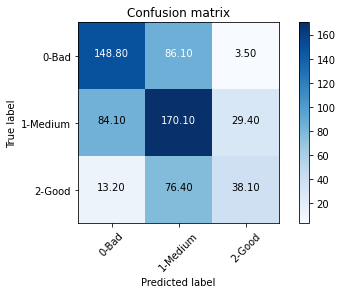

In [135]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
plot_confusion_matrix(conf_mat_mean,["0-Bad","1-Medium","2-Good"])
plt.savefig('MLP_PCA.png', transparent=True, dpi=300, bbox_inches="tight")